# Cycle-by-cycle features of oscillatory waveforms
In this notebook, we use neurodsp to break a neural signal into individual cycles of an oscillation of interest. For each cycle, we compute some features of its waveform.

In [1]:
import numpy as np
from neurodsp import shape

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

### Load neural signal

Text(0,0.5,'Voltage (uV)')

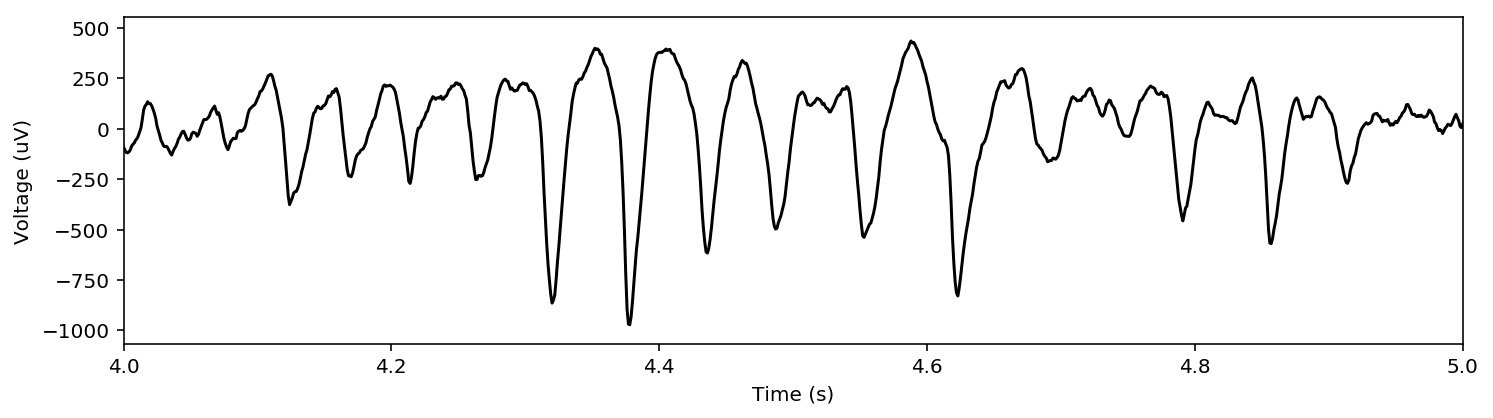

In [2]:
# Load signal
x = np.load('./data/sample_data_1.npy')
Fs = 1000
t = np.arange(0, len(x)/Fs, 1/Fs)
f_range = (13,30)

# Plot example signal
plt.figure(figsize=(12,3))
plt.plot(t, x, 'k')
plt.xlim((4,5))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')

# Compute features of each cycle

In [3]:
df = shape.features_by_cycle(x, Fs, f_range, center_extrema='T')
df.head()

,oscillator_amplitude,period,sample_last_peak,sample_next_peak,sample_trough,sample_zerox_rise,sample_zerox_decay,time_rise,time_trough,time_ptsym,time_rdsym,time_decay,time_peak,volt_amp,volt_rise,volt_trough,volt_ptsym,volt_rdsym,volt_decay,volt_peak
0,27.442521,46,128,174,148,157,139,26,18,0.550000,0.565217,20,22,102.297015,77.542938,-18.474257,90.102577,-49.508153,127.051091,108.576834
1,34.980215,48,174,222,185,197,178,37,19,0.525000,0.770833,11,21,133.618607,123.623268,-84.545266,-25.476585,-19.990679,143.613947,59.068681
2,19.290058,40,222,262,231,250,226,31,24,0.547170,0.775000,9,29,144.035222,161.573095,-87.419348,-48.341346,35.075745,126.497350,39.078002
3,18.898692,53,262,315,308,311,280,7,31,0.491803,0.132075,46,30,85.957768,113.252293,15.490505,89.644252,54.589050,58.663243,74.153747
4,20.070945,29,315,344,328,334,324,16,10,0.565217,0.551724,13,13,118.881224,140.175399,31.155748,159.898545,42.588350,97.587049,128.742797


# Visualize features for each cycle

In [4]:
# Limit dataframe to only features of interest for part of the signal
tlim = (3,4)
df_1sec = df.loc[(df['sample_trough'] > tlim[0]*Fs) & (df['sample_trough'] < tlim[1]*Fs)]

In [5]:
def plot_feature_at_trough(df, x, t, tlim, feature, plot_title,
                           mark_troughs=False, mark_peaks=False,
                           mark_zeroxR=False, mark_zeroxD=False):
    samps = np.argwhere(np.logical_and(t>=tlim[0], t<tlim[1]))
    plt.figure(figsize=(16,3))
    plt.plot(t[samps], x[samps],'k')
    if mark_troughs:
        plt.plot(t[df['sample_trough'].values], x[df['sample_trough'].values], 'bo')
    if mark_peaks:
        plt.plot(t[df['sample_next_peak'].values], x[df['sample_next_peak'].values], 'ro')
    if mark_zeroxR:
        plt.plot(t[df['sample_zerox_rise'].values], x[df['sample_zerox_rise'].values], 'go')
    if mark_zeroxD:
        plt.plot(t[df['sample_zerox_decay'].values], x[df['sample_zerox_decay'].values], 'mo')
    plt.xlim(tlim)

    ax = plt.gca()
    for i in range(len(df_1sec)):
        trough_sample = df['sample_trough'].values[i]
        label = df[feature].values[i]
        if type(label) is np.bool_:
            label_str = str(label)[0]
        elif abs(label) < 1:
            label_str = str(np.round(label,2))
        else:
            label_str = str(int(label))
        ax.text(t[trough_sample]-.01, x[trough_sample]-150, label_str, fontsize=15)
    plt.ylim((-1000,400))
    plt.xlabel('Time (s)', size=20)
    plt.ylabel('Voltage (uV)', size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.title(plot_title, size=20)

### Oscillator amplitude

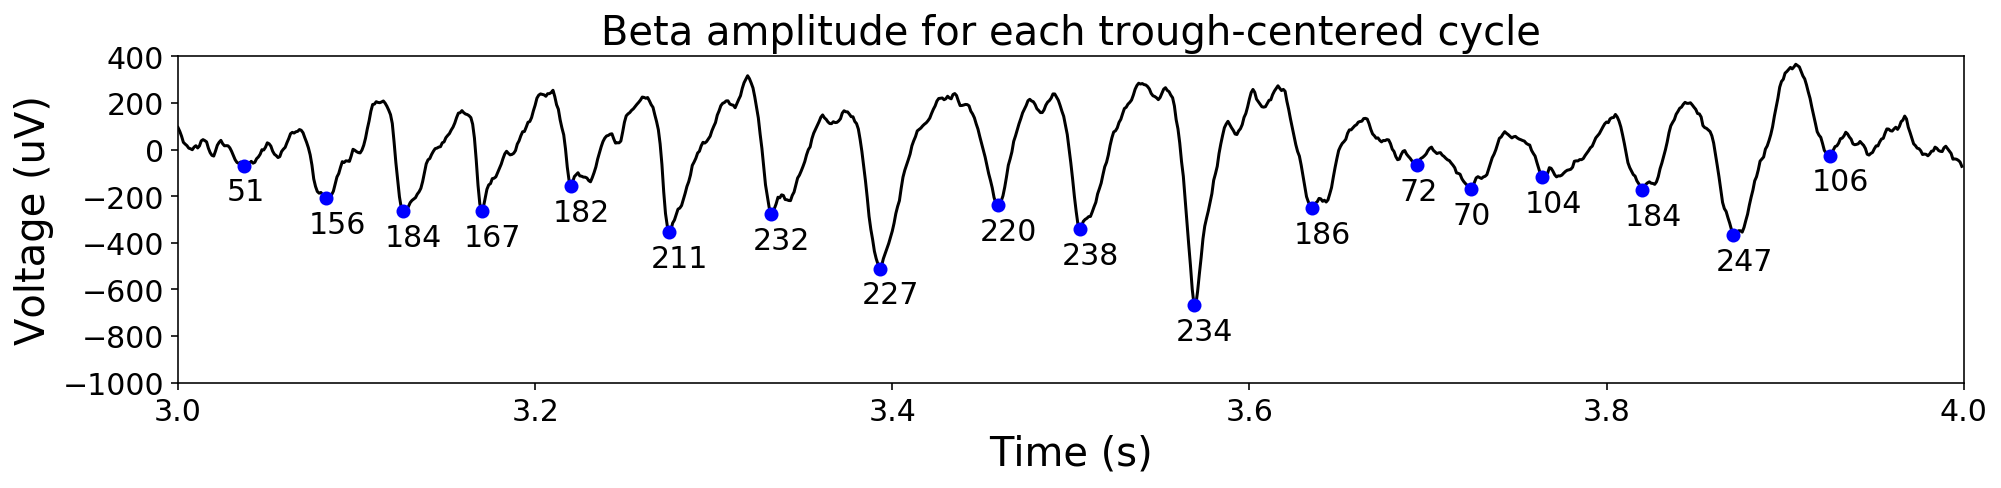

In [6]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'oscillator_amplitude', 'Beta amplitude for each trough-centered cycle',
                       mark_troughs=True)

### Trough duration

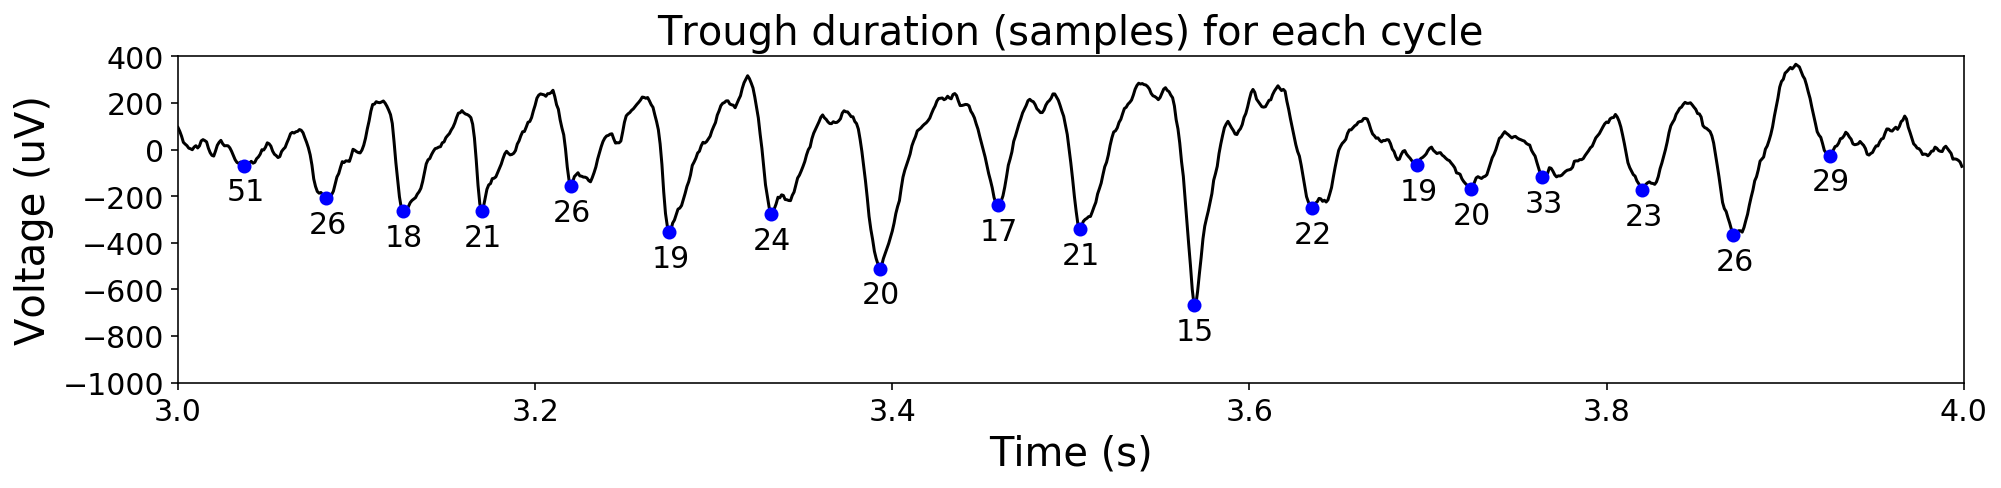

In [7]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'time_trough', 'Trough duration (samples) for each cycle',
                       mark_troughs=True)

### Rise-decay asymmetry in time

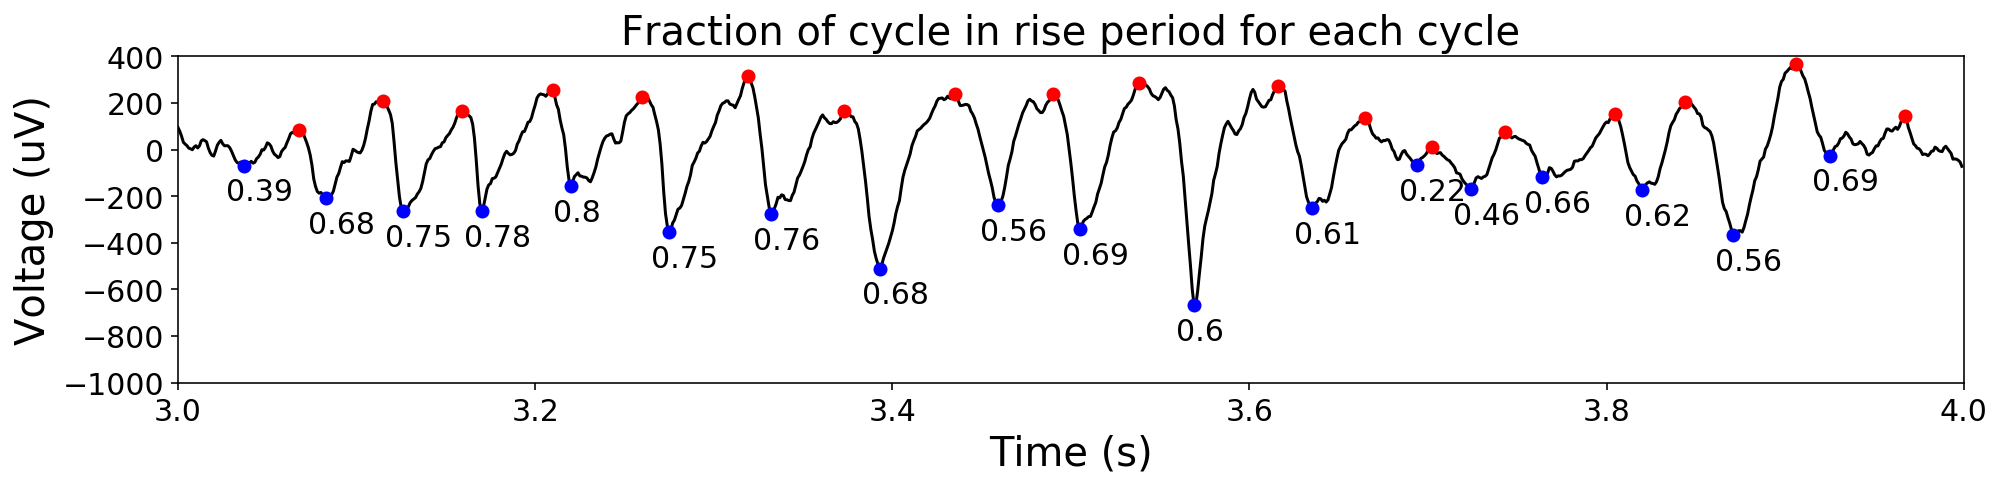

In [8]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'time_rdsym', 'Fraction of cycle in rise period for each cycle',
                       mark_troughs=True, mark_peaks=True)

### Rise-decay asymmetry in voltage

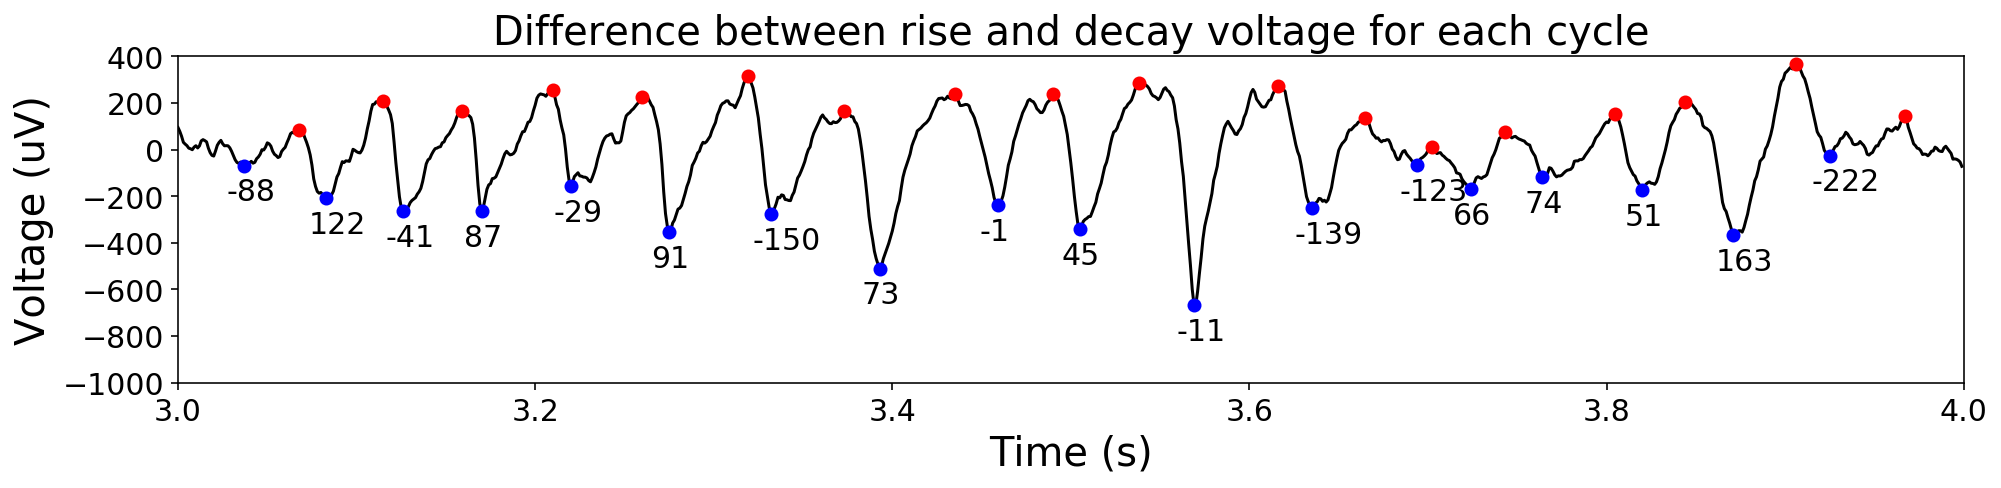

In [9]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'volt_rdsym', 'Difference between rise and decay voltage for each cycle',
                       mark_troughs=True, mark_peaks=True)

# Define oscillatory periods by amplitude

In [10]:
osc_kwargs = {'amplitude_fraction_threshold':.2,
              'amplitude_consistency_threshold':.4,
              'period_consistency_threshold':.4,
              'monotonicity_threshold':.4,
              'N_cycles_min':2
             }

df = shape.features_by_cycle(x, Fs, f_range, center_extrema='T',
                             estimate_oscillating_periods=True,
                             estimate_oscillating_periods_kwargs=osc_kwargs)

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


### Visualize which periods are in an oscillation

In [11]:
# Limit dataframe to only features of interest for part of the signal
tlim = (3, 4)
df_1sec = df.loc[(df['sample_trough'] > tlim[0]*Fs) & (df['sample_trough'] < tlim[1]*Fs)]

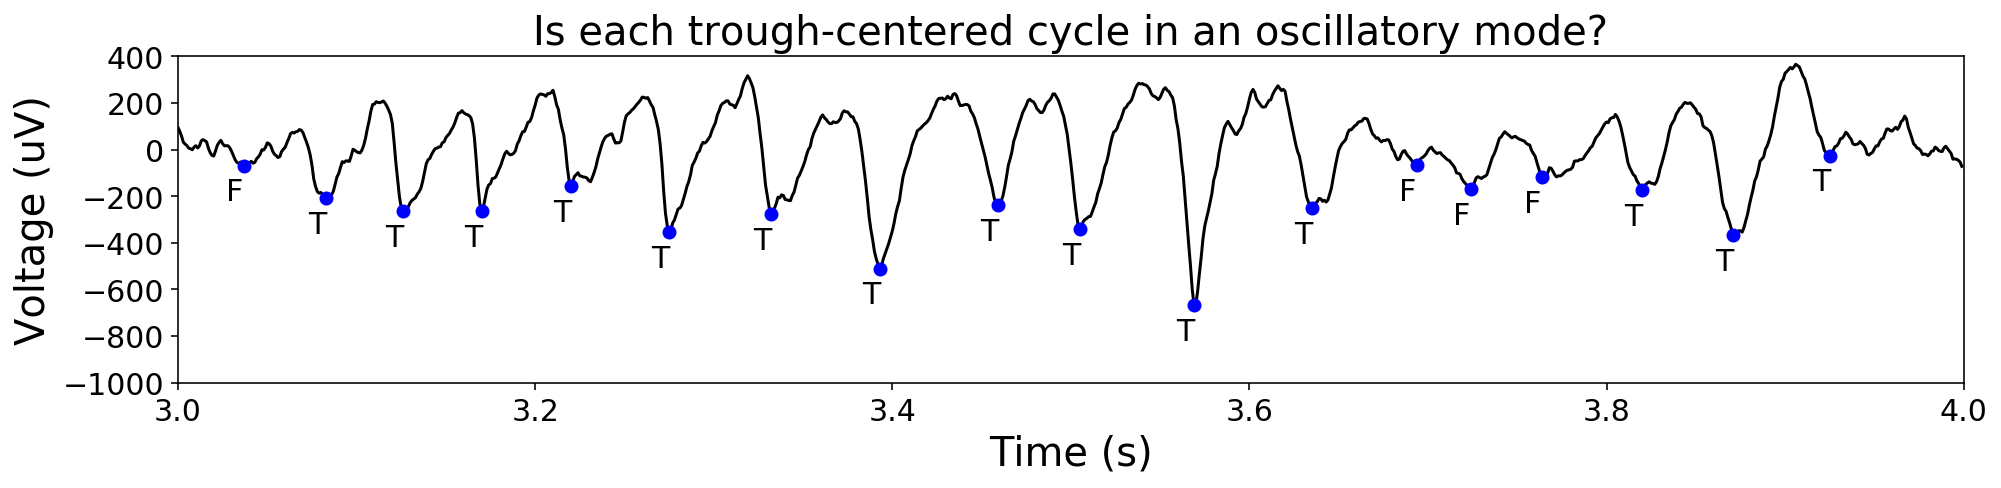

In [12]:
plot_feature_at_trough(df_1sec, x, t, tlim, 'is_cycle',
                       'Is each trough-centered cycle in an oscillatory mode?',
                       mark_troughs=True)